This notebook will focus on an intuitional and operational perspective of RRT (rapidly-exploring random trees). For a deeper mathematical treatment of RRT, I suggest the following material: 

LaValle, Steven M., and James J. Kuffner. "Rapidly-exploring random trees: Progress and prospects." Algorithmic and computational robotics: new directions 5 (2001): 293-308.

For a high-level description of RRT, I like the Wikipedia article: https://en.wikipedia.org/wiki/Rapidly-exploring_random_tree

Below: A picture of RRT, where red point is start, yellow is goal, green points are extended points along the path, and red path is found path.
<img src="./rrt.png" />

"A rapidly exploring random tree (RRT) is an algorithm designed to efficiently search nonconvex, high-dimensional spaces by randomly building a space-filling tree. The tree is constructed incrementally from samples drawn randomly from the search space and is inherently biased to grow towards large unsearched areas of the problem. RRTs were developed by Steven M. LaValle and James J. Kuffner Jr. They easily handle problems with obstacles and differential constraints (nonholonomic and kinodynamic) and have been widely used in autonomous robotic motion planning."

I think the last sentence is a little loaded and I would like to cover it in more depth in a different notebook.  One important thing is that RRT can handle path planning in continuous spaces, which typical path planners like breadth-first search, depth-first searchn, and Dijkstra's algorithm can't deal with since they may need to consider an infinite number of edges from any given node in the search graph. RRT handles this nicely by constructing a planning tree from a starting configuration, and sampling candidate nodes from the continuous configuration space. 

For now, let's look at how RRT works at a high-level.

"An RRT grows a tree rooted at the starting configuration by using random samples from the search space. As each sample is drawn, a connection is attempted between it and the nearest state in the tree. If the connection is feasible (passes entirely through free space and obeys any constraints), this results in the addition of the new state to the tree. With uniform sampling of the search space, the probability of expanding an existing state is proportional to the size of its Voronoi region. As the largest Voronoi regions belong to the states on the frontier of the search, this means that the tree preferentially expands towards large unsearched areas.

The length of the connection between the tree and a new state is frequently limited by a growth factor. If the random sample is further from its nearest state in the tree than this limit allows, a new state at the maximum distance from the tree along the line to the random sample is used instead of the random sample itself. The random samples can then be viewed as controlling the direction of the tree growth while the growth factor determines its rate. This maintains the space-filling bias of the RRT while limiting the size of the incremental growth.

RRT growth can be biased by increasing the probability of sampling states from a specific area. Most practical implementations of RRTs make use of this to guide the search towards the planning problem goals. This is accomplished by introducing a small probability of sampling the goal to the state sampling procedure. The higher this probability, the more greedily the tree grows towards the goal."


For now, let us analyze how RRT operates in a 2D open space, and look at how biasing the sampling process and controllign the growth factor impact performance. In this notebook, I'll be implementing from scratch, but for an (incomplete) implementation that involves obstacle avoidance, I suggest filling out Russ Tedrake's underactuated robotics homework on RRT: https://colab.research.google.com/github/RussTedrake/underactuated/blob/master/exercises/planning/rrt_planning/rrt_planning.ipynb#scrollTo=1i0oApvcbfM4

In order to keep track of the tree, I'll make a Node class

In [1]:
class Node:
    def __init__(self,p,parent):
        self.p = p
        self.parent = parent

We can use this for to create a root node of the tree at some arbitrary point (say, (2,3)), and all the subsequent children

In [2]:
import numpy as np
root = Node(p=np.array([2,3]),parent=None) #The root node, located at [2,3

Rather than have the class have children to keep track of the path, we'll instead have each node only keep track of it's position and (only) parent, and then we will simply keep track of a (discrete) set of all the points in the planning tree. When we want to know the plan from the root to any node in the planning tree, we can just start at the goal, and go up the parent tree until we get to the root. Let's make the set of nodes in our planning tree, and start with the root in it.

In [3]:
planning_tree = [root]

Now, let's make a function that samples random points from the continuous configuration space. For the purposes of this notebook, let's say we're only interested in points within a box cenetered around the root node. Then, we can just randomly sample points given the root and the length of the box. Remember from the Wikipedia article that this kind of random sampling has nice properties in terms of exploring at the frontier. Note that this function will just be giving us a position [x,y], we'll use it to create a Node by deciding a parent later on, but for now it just gives a tuple.

In [4]:
import random
def sample_random_point(center,l):
    #sample a random 2D point in the box centered around point center ([p-l,p+l],[p-1,p+l])
    return([random.uniform(center.p[0]-l,center.p[0]+1),random.uniform(center.p[1]-l,center.p[1]+l)])

Let's also define a goal point we want to get to. Since we don't know what the parent will be to the final configuration we end up, let's just represent the goal as a tuple of an x,y we want to get to that's somewhere inside the bounds of our search area.


In [5]:
l = 1 #size of sample region around center
goal = [root.p[0]+l/2,root.p[1]-l/2] #The goal is to the right and below the center of the root.

We can visualize the root as a red dot, the goal as a yellow dot, and a bunch of samples from the sample_random_point function as blue points on a 2D grid

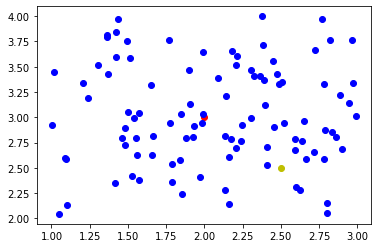

In [6]:
import matplotlib.pyplot as plt

plt.plot(root.p[0],root.p[1],'ro')
plt.plot(goal[0],goal[1],'yo')

random_points = [sample_random_point(root,1) for _ in range(100)] #A bunch of random samples

x,y = zip(*random_points) #convert a bunch of (x,y) into 2 bunches of separated x and y.

plt.plot(x,y,'bo')


plt.show()

Looks like good coverage of the space. Now let's say we're interested in trying to add one of these samples to our planning tree. What we'll do is first calculate the node in the tree that is currently closest to the newly sampled node. Luckily for us, we can just loop over all the points in the set planning_tree, and find the closest one in euclidean distance.

In [7]:
def nearest_neighbor(p,ptree):
    #given a 2d point p ([x,y]) and a planning tree (list consisting of Nodes), return the node that is closest to p
    best_point = None #default point is root
    best_distance = float("inf")
    for point in ptree:
        dist = np.linalg.norm(point.p-p)
        if dist < best_distance:
            best_point = point
            best_distance= dist
    return(best_point)

In [8]:
#sample a random point around the root, and check what's the closest in the planning_tree. since plannign tree is empty, confirm it's the root
assert nearest_neighbor(np.array(sample_random_point(root,1)),planning_tree) == root

When we sample a new point p, and get the nearest neighbor in the planning graph n, we want to walk in a straight line directly from n to p, since it's the direction of shortest distance. But we are limited by a growth factor, which only lets us steps of a certain, typically small, size. In case p is too far from n, then we truncate the step and only walking a fraction in the direction of p. We call this function the steering function, because it steers us in the direction of n from p, but only lets us way a small distance.

In [9]:
def steer(new,nearest,threshold=0.1):
    #return a point extending from nearest to new that is at most length threshold
    displacement = new-nearest.p #vector pointing from nearest to new
    dist = np.linalg.norm(displacement) #size of displacement
    if dist > threshold:
        scaled_displacement = threshold* (displacement / (np.linalg.norm(displacement))) #normalize the direction and scale to threshold size
        return nearest.p+scaled_displacement
    else:
        return new

To get a sense of how the steer function works, here's a plot of the red center point (only thing in planning graph), a blue randomly sampled point, and the green 
steering point, which only steps in a small direction towards blue from the red point (unless blue is close enough, which then the steering point and new point are equal)

We now have all the essential components of RRT! All we now do is just add the steering point to the planning tree by making the nearest neighbor its official parent, thereby adding our first edge into our plannign graph! Then, we just repeat the entire process! For the visuals, red is starting point, yellow is goal, green is steering points added to the planning graph, and blue edges represent the paths in our planning tree, and red path represents path to the goal found by RRT! We'll print out the number of steps taken until it finds the path in some delta ball.

RRT completed in  55  steps
RRT found a plan of length  14


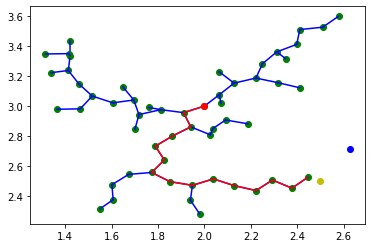

In [15]:
def RRT(root,goal,step_size=0.1,delta=0.1):
    planning_graph = [root]
    complete = False
    steps = 0
    while not complete:
        random_point = sample_random_point(root,1)
        nearest = nearest_neighbor(random_point,planning_graph)
        steering = steer(np.array(random_point),nearest,step_size)
        new_node = Node(steering,nearest)
        planning_graph.append(new_node)
        steps += 1
        
        if np.linalg.norm(new_node.p-np.array(goal)) < delta:
            complete = True
            goal_rep = new_node #the configuration close enough to the goal.
    print("RRT completed in ",steps, " steps")
        
    for point in planning_graph:
        plt.plot(point.p[0],point.p[1],'go')
        if point != root:
            x,y = zip(*(point.parent.p,point.p))
            plt.plot(x,y,'b')
            
    child = goal_rep
    parent = goal_rep.parent
    plan_length = 1
    while parent != root:
        x,y = zip(*(parent.p,child.p))
        plt.plot(x,y,'r')
    
        child = parent
        parent = child.parent
        plan_length +=1
    x,y = zip(*(root.p,child.p))
    plt.plot(x,y,'r')
    print("RRT found a plan of length ",plan_length)
        
        
    plt.plot(root.p[0],root.p[1],'ro')
    plt.plot(goal[0],goal[1],'yo')
    plt.plot(random_point[0],random_point[1],'bo')
    plt.show()


RRT(root,goal)

We can add a bias to RRT so that it samples the goal state epsilon amount of the time, biasing it to look in that direction and move towards it quicker.

RRT completed in  18  steps
RRT found a plan of length  8


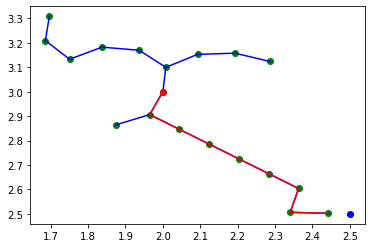

In [11]:
def RRT_greedy(root,goal,step_size=0.1,delta=0.1,epsilon=0.8):
    #1-epsilon percent of time, sample goal as random point
    planning_graph = [root]
    complete = False
    steps = 0
    while not complete:
        random_point = random.choices([sample_random_point(root,1),goal],[epsilon,1-epsilon])[0]
        nearest = nearest_neighbor(random_point,planning_graph)
        steering = steer(np.array(random_point),nearest,step_size)
        new_node = Node(steering,nearest)
        planning_graph.append(new_node)
        steps += 1
        
        if np.linalg.norm(new_node.p-np.array(goal)) < delta:
            complete = True
            goal_rep = new_node #the configuration close enough to the goal.
    print("RRT completed in ",steps, " steps")
        
    for point in planning_graph:
        plt.plot(point.p[0],point.p[1],'go')
        if point != root:
            x,y = zip(*(point.parent.p,point.p))
            plt.plot(x,y,'b')
            
    child = goal_rep
    parent = goal_rep.parent
    plan_length = 1
    while parent != root:
        x,y = zip(*(parent.p,child.p))
        plt.plot(x,y,'r')
    
        child = parent
        parent = child.parent
        plan_length +=1
    x,y = zip(*(root.p,child.p))
    plt.plot(x,y,'r')
    print("RRT found a plan of length ",plan_length)
        
        
    plt.plot(root.p[0],root.p[1],'ro')
    plt.plot(goal[0],goal[1],'yo')
    plt.plot(random_point[0],random_point[1],'bo')
    plt.show()


RRT_greedy(root,goal)

RRT gurantees nothing about the optimality of the path, just that if one exists, it will eventually return a path to it. There are variants to RRT, like RRT*, which have stronger properties than RRT, but that's for another notebook!